In [ ]:
# Spark kurulumu
!pip install pyspark

# TensorFlow ve diğer bağımlılıkların kurulumu
!pip install tensorflow matplotlib


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import numpy as np

# SparkSession başlat
spark = SparkSession.builder.appName("MNIST_Transfer_Learning") \
             .config("spark.driver.memory", "64g")  \
             .getOrCreate()

# MNIST veri kümesini yükle
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Veri setinin %10'unu al
train_size = len(x_train)
test_size = len(x_test)
train_indices = np.random.choice(train_size, size=int(train_size * 0.01), replace=False)
test_indices = np.random.choice(test_size, size=int(test_size * 0.01), replace=False)

x_train = x_train[train_indices]
y_train = y_train[train_indices]
x_test = x_test[test_indices]
y_test = y_test[test_indices]

# Veriyi normalize et (0-255 aralığından 0-1 aralığına)
x_train = (x_train / 255.0).astype("float16")
x_test = (x_test / 255.0).astype("float16")

# Siyah-beyaz resmi RGB'ye dönüştür
x_train_rgb = np.stack([x_train] * 3, axis=-1)
x_test_rgb = np.stack([x_test] * 3, axis=-1)

def resize_images(images):
    resized = [tf.image.resize(img, (224, 224)).numpy() for img in images]
    return np.array(resized)

def resize_images_bicubic(images):
    resized = [tf.image.resize(img, (224, 224), method="bicubic").numpy() for img in images]
    return np.array(resized)

x_train_resized = resize_images_bicubic(x_train_rgb)
x_test_resized = resize_images_bicubic(x_test_rgb)

# Çıkış verilerini one-hot encode
y_train_one_hot = to_categorical(y_train, 10)
y_test_one_hot = to_categorical(y_test, 10)

# Spark DataFrame'e dönüştür
train_data = [(x.tolist(), int(np.argmax(y))) for x, y in zip(x_train_resized, y_train_one_hot)]
test_data = [(x.tolist(), int(np.argmax(y))) for x, y in zip(x_test_resized, y_test_one_hot)]

train_df = spark.createDataFrame(train_data, ["image", "label"])
test_df = spark.createDataFrame(test_data, ["image", "label"])

# Veri boyutlarını göster
print("Training Data Size:", train_df.count())
print("Test Data Size:", test_df.count())

print("\nTraining Data Sample:")
train_df.show(5)
print("\nTest Data Sample:")
test_df.show(5)

Training Data Size: 600
Test Data Size: 100

Training Data Sample:
+--------------------+-----+
|               image|label|
+--------------------+-----+
|[[[0.0, 0.0, 0.0]...|    9|
|[[[0.0, 0.0, 0.0]...|    6|
|[[[0.0, 0.0, 0.0]...|    7|
|[[[0.0, 0.0, 0.0]...|    0|
|[[[0.0, 0.0, 0.0]...|    3|
+--------------------+-----+
only showing top 5 rows


Test Data Sample:
+--------------------+-----+
|               image|label|
+--------------------+-----+
|[[[0.0, 0.0, 0.0]...|    2|
|[[[0.0, 0.0, 0.0]...|    0|
|[[[0.0, 0.0, 0.0]...|    4|
|[[[0.0, 0.0, 0.0]...|    7|
|[[[0.0, 0.0, 0.0]...|    4|
+--------------------+-----+
only showing top 5 rows



In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# Pre-trained ResNet50 modelini yükle
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Katmanları dondur
base_model.trainable = False

# Yeni bir model oluştur
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(10, activation="softmax"),
])

# Modeli derle
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,114,826 (91.99 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Spark DataFrame'den NumPy dizisine dönüştür
train_images = np.array(train_df.select("image").rdd.map(lambda x: x[0]).collect())
train_labels = np.array(train_df.select("label").rdd.map(lambda x: x[0]).collect())

test_images = np.array(test_df.select("image").rdd.map(lambda x: x[0]).collect())
test_labels = np.array(test_df.select("label").rdd.map(lambda x: x[0]).collect())

# Modeli eğit
history = model.fit(
    train_images, train_labels,
    validation_data=(test_images, test_labels),
    epochs=45,
    batch_size=32
)


Epoch 1/45
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3889 - loss: 1.8236 - val_accuracy: 0.5200 - val_loss: 1.6759
Epoch 2/45
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3977 - loss: 1.8086 - val_accuracy: 0.5100 - val_loss: 1.6565
Epoch 3/45
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4189 - loss: 1.7526 - val_accuracy: 0.5200 - val_loss: 1.6238
Epoch 4/45
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4536 - loss: 1.6792 - val_accuracy: 0.5300 - val_loss: 1.5743
Epoch 5/45
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4732 - loss: 1.6247 - val_accuracy: 0.5500 - val_loss: 1.5430
Epoch 6/45
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4408 - loss: 1.6468 - val_accuracy: 0.5100 - val_loss: 1.5152
Epoch 7/45
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4654 - loss: 1.6313 - val_accuracy: 0.5900 - val_loss: 1.4854
Epoch 8/45
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4772 - loss: 1.6483 - val_accuracy: 0.5800 - v

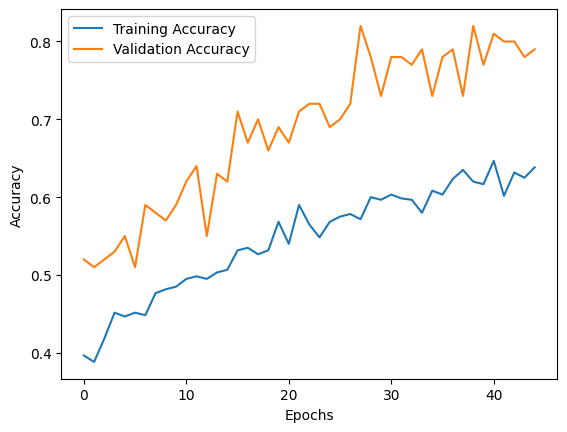

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7504 - loss: 0.8948
Test Loss: 0.844999372959137, Test Accuracy: 0.7900000214576721


In [ ]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama doğruluklarını görselleştir
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Test seti üzerindeki performans
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


In [ ]:
# Modeli kaydet
model.save("mnist_transfer_learning_resnet50.h5")
print("Model saved as mnist_transfer_learning_resnet50.h5")


Model saved as mnist_transfer_learning_resnet50.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


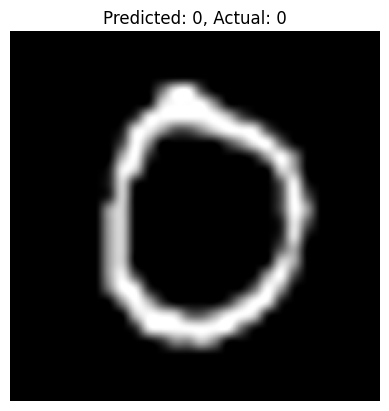

In [ ]:
# Bir test görüntüsü üzerinde tahmin yap
def predict_image(img_index, model):
    test_image = test_images[img_index].reshape(1, 224, 224, 3)
    prediction = model.predict(test_image)
    predicted_label = np.argmax(prediction)
    actual_label = test_labels[img_index]

    plt.imshow(test_images[img_index].astype("float32"))
    plt.title(f"Predicted: {predicted_label}, Actual: {actual_label}")
    plt.axis("off")
    plt.show()

# Test görüntüsü tahmini
predict_image(1, model)
